In [477]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Bebber et al methodology
This method calculates the risk of infection from rust spores that are depositing on a wet leaf surface, given time and temperature. The output is a single number that summaries the 0 - 1 the probabiltiy the rust spores have successfully infected the plant, given a wet period on the leaf of W hours long. The probabilty varies firstly on time, where the longer the wet period, the higher the probabiltiy of infection. The probabilty also varies on temperature, where rust develops fastest at its optimum temperature, then less with divergence from this until the temperature goes over the Tmin or Tmax points. 
<br>
<br>
The method assumes that there are spores landing constantly on the surface of the leafthroughout the wetperiod. This could be changed, but the code below assumes constant deposition. A population of spores that germinates on the leaf in an hour is called a cohort. The population germination on the leaf at hour 5 for example, is called cohort 5. The method calcualtes the probabiltiy that ANY of the cohorts of spores has germinated and infected the leaf in the wet period.  
<br>
<br>
At each timestep, the total probabiltiy of germination across all cohorts is calculated at each hour, given the temperature (T) and time into the wet period (t). This germination probabilty is then multipled by the infection risk accross all cohorts. The final answer is then the sum of infection risk at the end of the wet period.
<br>
<br>
This model uses the framework of the Bebber et al, but the infection and germination curves were found not to represent the devlopment of Wheat rust (Puccinia striiformis). The main change was to not use a Weibull function curve, but to use a logistc function instead, which fitted much better. However, this alters little and the function of the algorithms remain much the same. The validation against the data in Bebber is in a lower section.
<br>
<br>
The parameters were derived from a seperate paper focusing specifically on Puccinina striiform. Details on fitting are in a seperate notebook.

### Data Sources:
Raw data which is being fitted too:
<br>
https://www.apsnet.org/publications/phytopathology/backissues/Documents/1995Articles/Phyto85n04_409.PDF
<br>
<br>
Original paper for this methodology:
<br>
https://royalsocietypublishing.org/doi/pdf/10.1098/rstb.2015.0458
<br>
<br>
Supplermetary for the methodology with example (Very useful):
<br>
https://royalsocietypublishing.org/action/downloadSupplement?doi=10.1098%2Frstb.2015.0458&file=rstb20150458supp1.pdf

In [478]:
# first we need the two parameter sets for germination and infection risk

# Parameter order:
# p[0] = logistc curve gradient
# p[1] = logistic curve inflection point
# p[2] = temperature function exponent (custom feature)
# p[3] = minimum temperature for germination/infection
# p[4] = optimum temperature for germination/infection
# p[5] = maximum temperature for germination/infection

# parameters 3,4,5 are refered to as the cardninel temperatures (var = card)
# there are from the Yang temperature function used in the Bebber et al methodology

# pset for germination
p_g = [ 1.26122774,  3.87884279,  0.43784486,  2.44983614,  8.25878816,
       20.68979587]

# pset for infection
p_i = [ 0.35544141, 11.50749474,  3.44905594,  2.67326674,  7.80142393,
       16.38957626]

Text(0.5,0,'Wetness hour (h)')

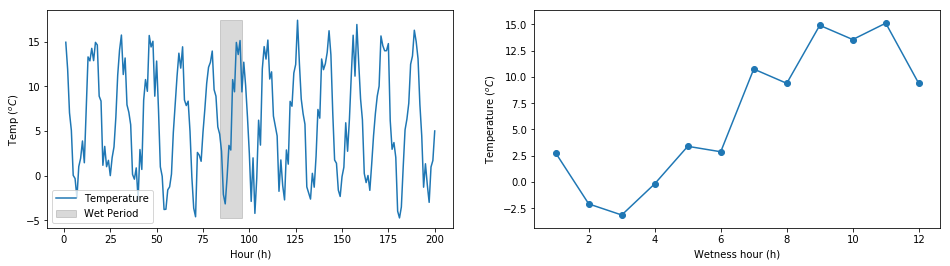

In [479]:
# next lets generate some data

# we will assume that we have plucked this data out of a timeseries 
# within the a wetperiod

# >>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<#
# length is the user input of how long we want
# the computation wet period to be. The longer
# this is, thegenerally the infection risk is 
# higher
length = 12
# >>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<#

tseries_length = 200

time_full = np.arange(1,tseries_length+1)
temp_full = (np.cos(time_full*0.4)+ 1)*8 - 5

temp_full = [i + (np.random.rand()*7) for i in temp_full]

wet_start = np.random.choice(np.arange(1,tseries_length - length))
wet_end = wet_start+length

temp = temp_full[wet_start:wet_end]
time = np.arange(1,length+1)

fig,axs = plt.subplots(1,2,figsize=(16,4))

axs[0].plot(time_full,temp_full,label='Temperature')
axs[0].set_xlabel('Hour (h)')
axs[0].set_ylabel('Temp ($^oC$)')

axs[0].fill_between([wet_start,wet_end],
                   [min(temp_full),min(temp_full)],
                   [max(temp_full),max(temp_full)],
                   color='k',alpha=0.15,
                   label='Wet Period')
axs[0].legend()

axs[1].plot(time,temp)
axs[1].scatter(time,temp)
axs[1].set_ylabel('Temperature ($^oC$)')
axs[1].set_xlabel('Wetness hour (h)')

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


Text(7.80142,1,'.  Happy spores at temperature 7.80142393')

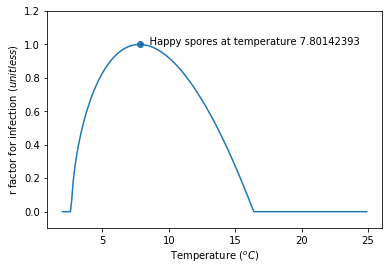

In [480]:
# before we make the further functions, we need the temperature function that everything uses

def rtheta(p,temp):
    
    tmax = p[2]
    topt = p[1]
    tmin = p[0]
    
    if type(temp) == list:
        temp = np.array(temp)
    
    ret = ((tmax - temp) / (tmax - topt)) * \
            ((temp - tmin) / (topt - tmin)) ** \
            ((topt - tmin) / (tmax - topt))
            

    try:
        ret[temp <= tmin] = 0
        ret[temp >= tmax] = 0
        
        ret[ret < 0] = 0
        
    except:
        
        if temp > tmax: ret = 0
        
        pass
    
    return ret

display_x = np.arange(2,25,0.1)
display_y = rtheta(p_i[3:],display_x)

plt.plot(display_x,display_y)
plt.ylabel('r factor for infection ($unitless$)')
plt.xlabel('Temperature ($^oC$)')
plt.ylim(-0.1,1.2)
plt.scatter(p_i[4],1)

plt.text(p_i[4],1,'.  Happy spores at temperature %s'%p_i[4])

In [481]:
# next we will make the functions for the literature

# these are the germination functions

def Hg(ti,te,j):
    """
    "Cummulative hazard function for germination"
    
    Function to alter the development time based off temperature.
    Given constant temperature at Topt, ret == ti
    
    But temperature obviously varies, so the development time
    is reduced by how far the temperature is from Topt
    """
    # pull out parameters
    pset = p_g
    
    card = pset[3:]
    lamba = pset[2]
    
    # get temperature response function
    # and put it to the power of lamba.
    r = rtheta(card,te)**lamba
    
    # find stepwise development
    c = r*(ti - j + 1)
    c[c < 0] = 0
    p = r*(ti - j)
    p[p < 0] = 0
    
    ret = c - p
    
    # return cumulative development time
    ret[:j-1] = 0
    
    return np.cumsum(ret)
    
def Fg(ti,te,i):
    """
    Function to find the total number of spores germinated at
    each hour accross all cohorts.
    
    Returns a matrix of [time x cohort] dimensions.
    
    ti = time array, starting from 1 denoting hours 
         in the wet period.
    te = temperature array corresponding with ti
    i = hour i into W
    """
    
    # make something to put results
    out = np.zeros([len(ti),len(ti)])
    
    # pull out parameter set
    pset = p_g
    
    lamda = pset[2]
    k = pset[0]
    infl = pset[1]
    
    # pull out the maximum germination proportion given temperature
    max_val = rtheta(p_g[3:],te)**lamda
    
    # loop through each cohort to find the hourly germination probability
    for j in range(1,out.shape[0] + 1):
        
        # find the development time
        current_h = Hg(ti,te,j)
        
        # find the development time of t - 1
        # this enables us to find the stepwise development
        previous_h = Hg(ti - 1,te,j)
        
        # find the germination probabilty given the altered development time
        current = max_val / (1 + np.e**(-k *(current_h - infl)))
        
        previous = max_val / (1 + np.e**(-k *(previous_h - infl)))
        
        # ignore probabilty past the ith step
        current[i:] = 0
        previous[i:] = 0
        
        # and find the stepwise hourly probabilty
        out[:,j-1] = current - previous
    
    return out

germ_prob = Fg(time,temp,16)

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


[Text(0.5,1,'Cohort 1'), Text(0.5,1,'Cohort 1')]

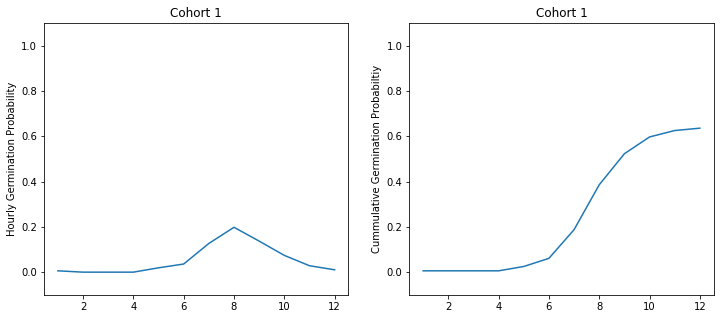

In [482]:
# lets display some results
# axis 0 is time
# axis 1 is cohort

cohort_1 = germ_prob[:,0]

fig,axs = plt.subplots(1,2,figsize=(12,5))

axs[0].plot(time,cohort_1)
axs[0].set_ylabel('Hourly Germination Probability')

axs[1].plot(time,np.cumsum(cohort_1))
axs[1].set_ylabel('Cummulative Germination Probabiltiy')

[axs[i].set_ylim(-0.1,1.1) for i in [0,1]]
[axs[i].set_title('Cohort 1') for i in [0,1]]

In [483]:
# Ok, lets get the infection probabiltiy bits

def Hi(ti,te,j):
    """
    Cummulative hazard function for infection
    
    """
    pset = p_i
    
    card = pset[3:]
    lamba = pset[2]
    
    r = rtheta(card,te)**lamba
    
    c = r*(ti - j + 1)
    c[c < 0] = 0
    p = r*(ti - j)
    p[p < 0] = 0
    
    ret = c - p
    
    ret[np.isnan(ret)] = 0
    
    ret[:j-1] = 0
    
    return np.cumsum(ret)
    
def Fi(ti,te,i):
    """
    Function to find the hourly infection risk accross all spores 
    at each hour. 
    
    Notice no 'current' - 'previous' caluclations here as the infection
    probabiltiy is not peicewise like the germination.
    """
    out = np.zeros([len(ti),len(ti)])
    
    # pull out parameter set
    pset = p_g
    
    k = pset[0]
    infl = pset[1]
    
    for j in range(1,out.shape[0] + 1):
        
        dev_t = Hi(ti,te,j)
        
        prob = 1 / (1 + np.e**(-k *(dev_t - infl)))
        
        prob[i:] = 0
        
        out[:,j-1] = prob
        
    return out

infection_prob = Fi(time,temp,16)

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


Text(0,0.5,'Infection Probability')

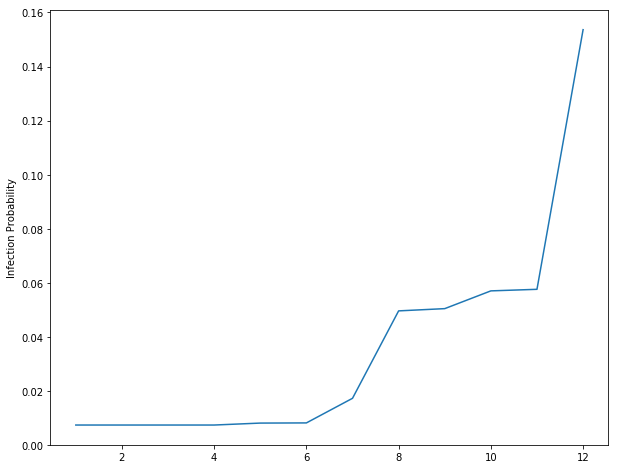

In [484]:
# lets display some results
# axis 0 is time
# axis 1 is cohort

cohort_1 = infection_prob[:,0]

plt.figure(figsize=(10,8))
plt.plot(time,cohort_1)

plt.ylabel('Infection Probability')

In [485]:
# Now we build the final function that brings this all together

def F(ti,te):
    
    """
    Final function to return the time x cohort matrix
    
    time = array counting from 1 of hours within W
    temp = array of temperatures that correspond with time
    
    returns i x j matrix of time on dimension 0 and cohort 
            in dimension 1.
    """
    
    # define wet period
    W = len(ti)
    
    # calculate the germination probabilty matrix
    fg = Fg(ti,te,W)
    
    # calculate the infectio probabiltiy matrix
    fi = Fi(ti,te,W)
    
    # manipulate the germination p matrix to 
    # make step 1, p = 0
    hgp = np.sum(fg,axis=1)
    hgp_0 = np.concatenate([np.zeros([1]),hgp[:-1]])
    
    fg0 = np.tile(hgp_0,(len(hgp_0),1))
    
    # multiply germination chance by infectio chance
    f = fg0 * fi
    
    return fg,fi,f

final_prob = F(time,temp)

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


In [486]:
print ('Infection risk = %s'%(sum(final_prob[-1][-1])))

Infection risk = 0.09826781515997222


Text(0,0.5,'Time')

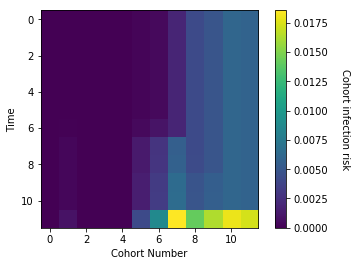

In [487]:
plt.imshow(final_prob[-1])
c = plt.colorbar()
c.set_label('Cohort infection risk',rotation=270,labelpad=22)
plt.xlabel('Cohort Number')
plt.ylabel('Time')

The results of this can be a little confusing. It is aparently normal for infection risk to be over 1 as the final infection risk is accrosss all cohorts. There would be something wrong if the infection risk went over 1 for a single cohort. It is best described by a few sentences from the paper:
<br>
<br>
<i>'Mean daily infection risk from 1990 to 2015 per pixel varied from zero to 3.82, with a median of 0.92, interquartile range
0.301.50. For reference, a value of one would occur if all
spores in a cohort germinated, and subsequently infected a
leaf. Mean daily infection risk per month was strongly correlated with mean canopy moisture per pixel (Spearman rank
correlation = 0.87), and followed a similar seasonal cycle with
a peak in October and minimum in January.'</i>
<br>
<br>
So basically a cumulative probability, across all cohorts at the final step, over 1 means infection is assumed. It is worth noting that as the wetness length increases, the chances increase allot. Also, if temperatures are more favourable (generally closer to 8oc) towards the end of the wet period, the infection risk goes up. If the favourable temperatures are in begining of the wetperiod, nothing really changes as the devlopment of the spores is very low at this point.

## Code validation against the data given in the supplementary material in Bebber et al.

### Data link:
https://royalsocietypublishing.org/action/downloadSupplement?doi=10.1098%2Frstb.2015.0458&file=rstb20150458supp1.pdf
<br>
<br>
We now have a section of code that can calculate the infection risk for Puccinian striiformis. To check this code is right, we can run the model with the data given in the supplermentary material. 
<br>
<br>
You will notice that certain parts of the code are different. This is due to the difference in development of coffe rust and wheat rust. Also the parameters are also different - also reflecting this physiological change.

In [488]:
bp_g = [12.909, 21.410, 30.943, 13.363, 1.287]

bp_i = [11.570, 11.570, 32.109, 19.121, 2.141]

Text(0.5,0,'Time (h)')

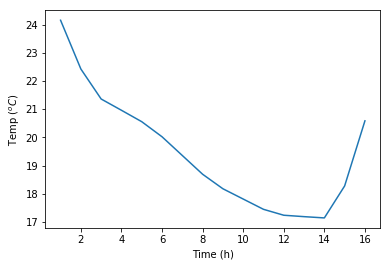

In [489]:
# this is the time and temperature data from the readout on page 6
# this data is within a wet period
b_time = np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
b_temp = np.array([25.02, 23.29, 21.56, 21.16, 20.76, 20.35, 19.69, 19.02, 18.36,
       17.99, 17.63, 17.26, 17.21, 17.16, 17.12, 19.43, 21.74])

# bebber interpolates the temperatures for some reason so we shall do the same
b_time = b_time[:-1]
b_temp = b_temp[:-1] + np.diff(b_temp) /2

plt.plot(b_time,b_temp)
plt.ylabel('Temp ($^oC$)')
plt.xlabel('Time (h)')

Our Hg for cohort 1:
[0.03249719 0.08309996 0.14254804 0.20791407]
Bebber Hg for cohort 1:
[0.03247 0.08304 0.14247 0.20782]
 
Our Hg for cohort 2:
[0.         0.03513591 0.08634795 0.14565669]
Bebber Hg for cohort 1:
[0.      0.0351  0.08629 0.14558]
 
Our Hg for cohort 3:
[0.         0.         0.03555895 0.08665096]
Bebber Hg for cohort 1:
[0.      0.      0.03553 0.08659]
 
Our Hg for cohort 4:
[0.         0.         0.         0.03547561]
Bebber Hg for cohort 1:
[0.      0.      0.      0.03544]
 


/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


Text(0.5,0,'Infection Hour')

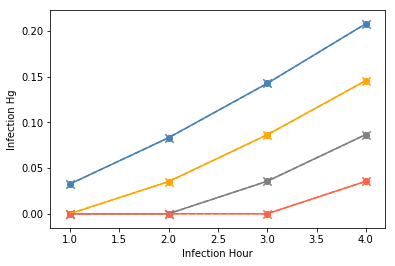

In [490]:
# first lets validate the germination H matrix

def Hg_bebber(ti,te,j):
    
    pset = bp_g
    
    card = pset[:3]
    alpha = pset[3]
    gamma = pset[4]
    
    r = rtheta(card,te)
    
    c = r*(((ti - j + 1)/alpha)**gamma)
    c[c < 0] = 0
    p = r*(((ti - j)/alpha)**gamma)
    p[p < 0] = 0
    
    ret = c - p
    
    ret[:j-1] = 0
    
    ret[np.isnan(ret)] = 0
    
    return np.cumsum(ret)

cweel = ['steelblue','orange','grey','tomato']

x_ = range(1,5)

for i in x_:
    
    # set a cohort to validate
    cohort = i

    our_hg = Hg_bebber(b_time,b_temp,cohort)

    bebber_hg = np.array([[0.03247, 0.00000, 0.00000, 0.00000],
            [0.08304, 0.03510, 0.00000, 0.00000],
            [0.14247, 0.08629, 0.03553, 0.00000],
            [0.20782, 0.14558, 0.08659, 0.03544]])



    print ('Our Hg for cohort %s:'%cohort)
    print (our_hg[:4])
    print ('Bebber Hg for cohort 1:')
    print (bebber_hg[:,cohort-1])
    print (' ')
    
    plt.plot(x_,our_hg[:4],c=cweel[i-1])
    plt.plot(x_,bebber_hg[:,cohort-1],c=cweel[i-1],ls='--')
    
    plt.scatter(x_,our_hg[:4],c=cweel[i-1])
    plt.scatter(x_,bebber_hg[:,cohort-1],c=cweel[i-1],marker='x',s=70)
    
plt.ylabel('Infection Hg')
plt.xlabel('Infection Hour')

Our Fg for cohort 1:
[0.03197483 0.04521504 0.05012911 0.05217759]
Bebber Fg for cohort 1:
[0.03194 0.04774 0.0531  0.05486]
 


/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  


Our Fg for cohort 2:
[0.         0.03452581 0.04779083 0.05254268]
Bebber Fg for cohort 2:
[0.      0.03449 0.04818 0.05281]
 
Our Fg for cohort 3:
[0.         0.         0.03493416 0.04814916]
Bebber Fg for cohort 3:
[0.      0.      0.0349  0.04805]
 
Our Fg for cohort 4:
[0.         0.         0.         0.03485373]
Bebber Fg for cohort 4:
[0.      0.      0.      0.03482]
 


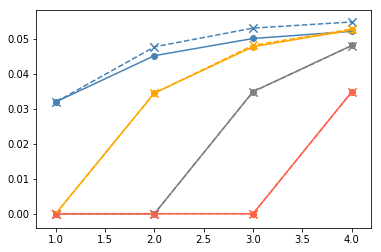

In [491]:
# validate the germination risk

def Fg_bebber(ti,te,i):
    
    out = np.zeros([len(ti),len(ti)])
    
    for j in range(1,out.shape[0] + 1):
        
        current_h = Hg_bebber(ti,te,j)
        
        previous_h = Hg_bebber(ti - 1,te,j)
      
        current = 1 - np.e**(-current_h)
        
        previous = 1 - np.e**(-previous_h)
        
        current[i:] = 0
        previous[i:] = 0
        
        out[:,j-1] = current - previous
        
    return out

our_fg = Fg_bebber(b_time,b_temp,16)
bebber_fg = np.array([[0.03194, 0.00000, 0.00000, 0.00000],
                    [0.04774, 0.03449, 0.00000, 0.00000],
                    [0.05310, 0.04818, 0.03490, 0.00000],
                    [0.05486, 0.05281, 0.04805, 0.03482]])


x_ = range(1,5)

for i in x_:

    cohort = i
    print ('Our Fg for cohort %s:'%cohort)
    print (our_fg[:4,cohort-1])
    print ('Bebber Fg for cohort %s:'%cohort)
    print (bebber_fg[:4,cohort-1])
    print (' ')
    
    plt.plot(x_,our_fg[:4,cohort-1],c=cweel[i-1])
    plt.plot(x_,bebber_fg[:,cohort-1],c=cweel[i-1],ls='--')
    
    plt.scatter(x_,our_fg[:4,cohort-1],c=cweel[i-1])
    plt.scatter(x_,bebber_fg[:,cohort-1],c=cweel[i-1],marker='x',s=70)

Our Hi for cohort 1:
[0.0006987  0.00360006 0.00935722 0.01811872]
Bebber Hi for cohort 1:
[0.0007546 0.0038762 0.0100551 0.019451 ]
 
Our Hi for cohort 2:
[0.         0.00085067 0.00407111 0.0100425 ]
Bebber Hi for cohort 1:
[0.        0.0009156 0.0043726 0.0107773]
 
Our Hi for cohort 3:
[0.         0.         0.00094422 0.0042845 ]
Bebber Hi for cohort 1:
[0.       0.       0.001014 0.004597]
 
Our Hi for cohort 4:
[0.         0.         0.         0.00097936]
Bebber Hi for cohort 1:
[0.       0.       0.       0.001051]
 


/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Text(0.5,0,'Infection Hour')

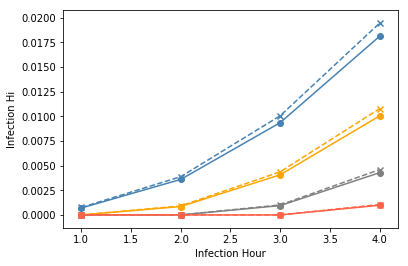

In [492]:
# Hi matrix validation

def Hi_bebber(ti,te,j):
    
    pset = bp_i
    
    card = pset[:3]
    alpha = pset[3]
    gamma = pset[4]
    
    gamma = gamma
    
    r = rtheta(card,te)
    
    c = r*(((ti - j + 1)/alpha)**gamma)
    c[c < 0] = 0
    p = r*(((ti - j)/alpha)**gamma)
    p[p < 0] = 0
    
    ret = c - p
    
    ret[:j-1] = 0
    
    ret[np.isnan(ret)] = 0
    
    return np.cumsum(ret)


cweel = ['steelblue','orange','grey','tomato']

x_ = range(1,5)

for i in range(1,5):
    
    # set a cohort to validate
    cohort = i

    our_hi = Hi_bebber(b_time,b_temp,cohort)

    bebber_hi = np.array([[0.0007546, 0.0000000, 0.000000, 0.000000],
                        [0.0038762, 0.0009156, 0.000000, 0.000000],
                        [0.0100551, 0.0043726, 0.001014, 0.000000],
                        [0.0194510, 0.0107773, 0.004597, 0.001051]])


    print ('Our Hi for cohort %s:'%cohort)
    print (our_hi[:4])
    print ('Bebber Hi for cohort 1:')
    print (bebber_hi[:,cohort-1])
    print (' ')
    
    plt.plot(x_,our_hi[:4],c=cweel[i-1])
    plt.plot(x_,bebber_hi[:,cohort-1],c=cweel[i-1],ls='--')
    
    plt.scatter(x_,our_hi[:4],c=cweel[i-1])
    plt.scatter(x_,bebber_hi[:,cohort-1],c=cweel[i-1],marker='x')
    
plt.ylabel('Infection Hi')
plt.xlabel('Infection Hour')

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Our Fi for cohort 1:
[0.00069846 0.00359359 0.00931357 0.01795557]
Bebber Fi for cohort 1:
[0.0007543 0.0038687 0.0100047 0.0192631]
 
Our Fi for cohort 2:
[0.         0.00085031 0.00406283 0.00999225]
Bebber Fi for cohort 2:
[0.        0.0009151 0.0043631 0.0107194]
 
Our Fi for cohort 3:
[0.         0.         0.00094378 0.00427534]
Bebber Fi for cohort 3:
[0.       0.       0.001013 0.004587]
 
Our Fi for cohort 4:
[0.         0.         0.         0.00097888]
Bebber Fi for cohort 4:
[0.      0.      0.      0.00105]
 


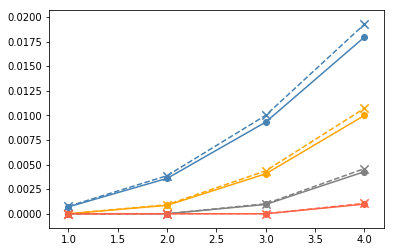

In [493]:
# the last function - the infection probability
def Fi_bebber(ti,te,i):
    
    out = np.zeros([len(ti),len(ti)])
    
    for j in range(1,out.shape[0] + 1):
        
        current_h = Hi_bebber(ti,te,j)   
      
        current = 1 - np.e**(-current_h)
    
        current[i:] = 0
        
        out[:,j-1] = current
        
    return out

our_fi = Fi_bebber(b_time,b_temp,16)
bebber_fi = np.array([[0.0007543, 0.0000000, 0.000000, 0.00000],
                    [0.0038687, 0.0009151, 0.000000, 0.00000],
                    [0.0100047, 0.0043631, 0.001013, 0.00000],
                    [0.0192631, 0.0107194, 0.004587, 0.00105]])

x_ = range(1,5)

for i in x_:

    cohort = i
    print ('Our Fi for cohort %s:'%cohort)
    print (our_fi[:4,cohort-1])
    print ('Bebber Fi for cohort %s:'%cohort)
    print (bebber_fi[:4,cohort-1])
    print (' ')
    
    plt.plot(x_,our_fi[:4,cohort-1],c=cweel[i-1])
    plt.plot(x_,bebber_fi[:,cohort-1],c=cweel[i-1],ls='--')
    
    plt.scatter(x_,our_fi[:4,cohort-1],c=cweel[i-1])
    plt.scatter(x_,bebber_fi[:,cohort-1],c=cweel[i-1],marker='x',s=70)

In [494]:
# and finally, bring this all together to work out the final infection risk
def F_bebber(ti,te):
    
    # define wet period
    W = len(ti)
    
    # calculate the germination probabilty matrix
    fg = Fg_bebber(ti,te,W)
    
    # calculate the infectio probabiltiy matrix
    fi = Fi_bebber(ti,te,W)
    
    # manipulate the germination p matrix to 
    # make step 1 p = 0
    hgp = np.sum(fg,axis=1)
    hgp_0 = np.concatenate([np.zeros([1]),hgp[:-1]])
    
    fg0 = np.tile(hgp_0,(len(hgp_0),1))
    
    f = fg0 * fi
    
    return f

our_inf_risk = F_bebber(b_time,b_temp)

/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/acornelius/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in power
/home/acornelius/anaconda3/en

In [495]:
print ('Final Readout:')
print (' ')
print ('Our infection risk:')
print (sum(our_inf_risk[-1]))
print (' ')
print ('Bebber infection risk:')
print ( 0.3914)

Final Readout:
 
Our infection risk:
0.3813836513848268
 
Bebber infection risk:
0.3914


The slight difference in answers is likely due to precision of the temperature data and the procesion of the parameters given. But all the matricies look the same for all cohorts, so the process is clearly on track.